In [2]:
import sys

#sys.path.append('/root/lib/')

import ROOT as r
import os
import json
import pandas as pd
import uproot 
import awkward as ak
import array as arr
import numpy as np
import shutil

sys.path.append(os.getcwd()+ '/../utilities/')
from milliqanProcessor import *
from milliqanScheduler import *
from milliqanCuts import *
from milliqanPlotter import *

In [2]:
@mqCut
def selectPanels(self, cutName='selectPanels', cut=False, channel=None, branches=None):

    mask = self.events['chan'] == channel
    panelHits = self.events['area'][mask]

    self.events[cutName] = panelHits
    panel = cutName.split('_')[-1]
    self.events['riseSamples_'+panel] = self.events['riseSamples'][mask]
    self.events['fallSamples_'+panel] = self.events['fallSamples'][mask]
    self.events['duration_'+panel] = self.events['duration'][mask]

@mqCut
def riseSamplesCut(self, cutName='riseSamplesCut', cut=False, samples=3, branches=None):

    mask = self.events['riseSamples'] >= samples
    self.events[cutName] = mask

    if cut:
        self.cutBranches(branches, cutName)

@mqCut
def fallSamplesCut(self, cutName='fallSamplesCut', cut=False, samples=3, branches=None):

    mask = self.events['fallSamples'] >= samples
    self.events[cutName] = mask

    if cut:
        self.cutBranches(branches, cutName)

In [17]:
if __name__ == "__main__":

    filelist = [
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1300_v35_zeroBias_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1400_v35_zeroBias_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1500_v35_zeroBias_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1600_v35_zeroBias_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1700_v35_zeroBias_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1900_v35_zeroBias_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1300_v35_cosmic_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1400_v35_cosmic_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1500_v35_cosmic_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1600_v35_cosmic_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1700_v35_cosmic_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1800_v35_cosmic_beamOff_tight.root',
        #'/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1900_v35_cosmic_beamOff_tight.root',
    ]

    print("Running on files {}".format(filelist))

    #define the necessary branches to run over
    branches = ['event', 'tTrigger', 'boardsMatched', 'pickupFlag', 'pickupFlagTight', 'fileNumber', 'runNumber', 'type', 'ipulse', 'nPE', 'chan', 'duration',
                'time_module_calibrated', 'timeFit_module_calibrated', 'row', 'column', 'layer', 'height', 'area', 'npulses', 'timeFit', 'sidebandRMS', 'riseSamples', 'fallSamples']


    #define the milliqan cuts object
    mycuts = milliqanCuts()

    setattr(milliqanCuts, "selectPanels", selectPanels)
    setattr(milliqanCuts, "fallSamplesCut", fallSamplesCut)
    setattr(milliqanCuts, "riseSamplesCut", riseSamplesCut)

    #require pulses are not pickup
    pickupCut = getCutMod(mycuts.pickupCut, mycuts, 'pickupCut', tight=False, cut=True, branches=branches)

    #require that all digitizer boards are matched
    boardMatchCut = getCutMod(mycuts.boardsMatched, mycuts, 'boardMatchCut', cut=True, branches=branches)

    #greater than or equal to one hit per layer
    hitInAllLayers = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'hitInAllLayers', cut=True, branches=branches, multipleHits=False)

    #exactly one hit per layer
    oneHitPerLayer = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'oneHitPerLayer', cut=True, branches=branches, multipleHits=False)

    #four layer cut
    fourLayerCut = getCutMod(mycuts.fourLayerCut, mycuts, 'fourLayerCut', cut=True, branches=branches)

    #panel veto
    panelVeto = getCutMod(mycuts.panelVeto, mycuts, 'panelVeto', nPECut=40e3, cut=True, branches=branches)

    #nPE Cut
    nPECut = getCutMod(mycuts.nPECut, mycuts, 'nPECut', nPECut=100, cut=True, branches=branches)

    #area cut
    areaCut = getCutMod(mycuts.areaCut, mycuts, 'areaCut', areaCut=300000, cut=True, branches=branches)

    #first pulse cut
    firstPulseCut = getCutMod(mycuts.firstPulseCut, mycuts, 'firstPulseCut', cut=True, branches=branches)

    sidebandRMSCut = getCutMod(mycuts.sidebandRMSCut, mycuts, 'sidebandRMSCut', cutVal=0.5, cut=True)

    #rise samples cut
    riseSamplesCut = getCutMod(mycuts.riseSamplesCut, mycuts, 'riseSamplesCut', samples=3, cut=True)

    #fall samples cut
    fallSamplesCut = getCutMod(mycuts.fallSamplesCut, mycuts, 'fallSamplesCut', samples=5, cut=True)


    #get nPE of each panel
    panel68 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel68', channel=68)
    panel69 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel69', channel=69)
    panel70 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel70', channel=70)
    panel71 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel71', channel=71)
    panel72 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel72', channel=72)
    panel73 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel73', channel=73)
    panel74 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel74', channel=74)
    panel75 = getCutMod(mycuts.selectPanels, mycuts, 'nPE_panel75', channel=75)


    #require hit time is in trigger window
    centralTime = getCutMod(mycuts.centralTime, mycuts, 'centralTime', cut=True, branches=branches)

    #create all plots for timing differences 64 paths, 3 timing differences each
    timingHistos = []
    cutNames = []
    nbins = 100
    minx = -50
    maxx = 50

    h_nPE68 = r.TH1F('h_nPE68', 'Panel 68 nPE', 200, 0, 20000)
    h_nPE69 = r.TH1F('h_nPE69', 'Panel 69 nPE', 200, 0, 20000)
    h_nPE70 = r.TH1F('h_nPE70', 'Panel 70 nPE', 200, 0, 20000)
    h_nPE71 = r.TH1F('h_nPE71', 'Panel 71 nPE', 200, 0, 20000)
    h_nPE72 = r.TH1F('h_nPE72', 'Panel 72 nPE', 200, 0, 20000)
    h_nPE73 = r.TH1F('h_nPE73', 'Panel 73 nPE', 200, 0, 20000)
    h_nPE74 = r.TH1F('h_nPE74', 'Panel 74 nPE', 200, 0, 20000)
    h_nPE75 = r.TH1F('h_nPE75', 'Panel 75 nPE', 200, 0, 20000)

    h_sidebands = r.TH1F('h_sidebands', 'RMS Sidebands', 100, 0, 50)

    riseBins = 30
    riseMax = 30
    areaBins = 200
    areaMax = 10000
    h_riseArea68 = r.TH2F('h_riseArea68', 'Panel 68 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea69 = r.TH2F('h_riseArea69', 'Panel 69 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea70 = r.TH2F('h_riseArea70', 'Panel 70 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea71 = r.TH2F('h_riseArea71', 'Panel 71 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea72 = r.TH2F('h_riseArea72', 'Panel 72 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea73 = r.TH2F('h_riseArea73', 'Panel 73 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea74 = r.TH2F('h_riseArea74', 'Panel 74 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_riseArea75 = r.TH2F('h_riseArea75', 'Panel 75 Area vs Rise Time', areaBins, 0, areaMax, riseBins, 0, riseMax)

    h_fallArea68 = r.TH2F('h_fallArea68', 'Panel 68 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea69 = r.TH2F('h_fallArea69', 'Panel 69 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea70 = r.TH2F('h_fallArea70', 'Panel 70 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea71 = r.TH2F('h_fallArea71', 'Panel 71 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea72 = r.TH2F('h_fallArea72', 'Panel 72 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea73 = r.TH2F('h_fallArea73', 'Panel 73 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea74 = r.TH2F('h_fallArea74', 'Panel 74 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)
    h_fallArea75 = r.TH2F('h_fallArea75', 'Panel 75 Area vs Fall Time', areaBins, 0, areaMax, riseBins, 0, riseMax)

    h_durationArea68 = r.TH2F('h_durationArea68', 'Panel 68 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea69 = r.TH2F('h_durationArea69', 'Panel 69 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea70 = r.TH2F('h_durationArea70', 'Panel 70 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea71 = r.TH2F('h_durationArea71', 'Panel 71 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea72 = r.TH2F('h_durationArea72', 'Panel 72 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea73 = r.TH2F('h_durationArea73', 'Panel 73 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea74 = r.TH2F('h_durationArea74', 'Panel 75 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)
    h_durationArea75 = r.TH2F('h_durationArea75', 'Panel 76 Area vs Duration', areaBins, 0, areaMax, 200, 0, 1000)

    cutflow = [mycuts.totalEventCounter, mycuts.fullEventCounter, 
                boardMatchCut, 
                #pickupCut, 
                firstPulseCut,
                #nPECut,
                #centralTime,
                sidebandRMSCut, 
                riseSamplesCut, 
                fallSamplesCut,
                panel68, 
                panel69, 
                panel70, 
                panel71, 
                panel72, 
                panel73, 
                panel74,
                panel75,
            ]
    
    #define milliqan plotter
    myplotter = milliqanPlotter()
    myplotter.dict.clear()

    myplotter.addHistograms(h_nPE68, 'nPE_panel68')
    myplotter.addHistograms(h_nPE69, 'nPE_panel69')
    myplotter.addHistograms(h_nPE70, 'nPE_panel70')
    myplotter.addHistograms(h_nPE71, 'nPE_panel71')
    myplotter.addHistograms(h_nPE72, 'nPE_panel72')
    myplotter.addHistograms(h_nPE73, 'nPE_panel73')
    myplotter.addHistograms(h_nPE74, 'nPE_panel74')
    myplotter.addHistograms(h_nPE75, 'nPE_panel75')

    myplotter.addHistograms(h_sidebands, 'sidebandsAfterCut')
    myplotter.addHistograms(h_riseArea68, ['nPE_panel68', 'riseSamples_panel68'])
    myplotter.addHistograms(h_riseArea69, ['nPE_panel69', 'riseSamples_panel69'])
    myplotter.addHistograms(h_riseArea70, ['nPE_panel70', 'riseSamples_panel70'])
    myplotter.addHistograms(h_riseArea71, ['nPE_panel71', 'riseSamples_panel71'])
    myplotter.addHistograms(h_riseArea72, ['nPE_panel72', 'riseSamples_panel72'])
    myplotter.addHistograms(h_riseArea73, ['nPE_panel73', 'riseSamples_panel73'])
    myplotter.addHistograms(h_riseArea74, ['nPE_panel74', 'riseSamples_panel74'])
    myplotter.addHistograms(h_riseArea75, ['nPE_panel75', 'riseSamples_panel75'])

    myplotter.addHistograms(h_fallArea68, ['nPE_panel68', 'fallSamples_panel68'])
    myplotter.addHistograms(h_fallArea69, ['nPE_panel69', 'fallSamples_panel69'])
    myplotter.addHistograms(h_fallArea70, ['nPE_panel70', 'fallSamples_panel70'])
    myplotter.addHistograms(h_fallArea71, ['nPE_panel71', 'fallSamples_panel71'])
    myplotter.addHistograms(h_fallArea72, ['nPE_panel72', 'fallSamples_panel72'])
    myplotter.addHistograms(h_fallArea73, ['nPE_panel73', 'fallSamples_panel73'])
    myplotter.addHistograms(h_fallArea74, ['nPE_panel74', 'fallSamples_panel74'])
    myplotter.addHistograms(h_fallArea75, ['nPE_panel75', 'fallSamples_panel75'])

    myplotter.addHistograms(h_durationArea68, ['nPE_panel68', 'duration_panel68'])
    myplotter.addHistograms(h_durationArea69, ['nPE_panel69', 'duration_panel69'])
    myplotter.addHistograms(h_durationArea70, ['nPE_panel70', 'duration_panel70'])
    myplotter.addHistograms(h_durationArea71, ['nPE_panel71', 'duration_panel71'])
    myplotter.addHistograms(h_durationArea72, ['nPE_panel72', 'duration_panel72'])
    myplotter.addHistograms(h_durationArea73, ['nPE_panel73', 'duration_panel73'])
    myplotter.addHistograms(h_durationArea74, ['nPE_panel74', 'duration_panel74'])
    myplotter.addHistograms(h_durationArea75, ['nPE_panel75', 'duration_panel75'])

    for key, value in myplotter.dict.items():
        if value not in cutflow:
            cutflow.append(value)

    #create a schedule of the cuts
    myschedule = milliQanScheduler(cutflow, mycuts, myplotter)

    #print out the schedule
    myschedule.printSchedule()

    #create the milliqan processor object
    myiterator = milliqanProcessor(filelist, branches, myschedule, step_size=10000, qualityLevel='override')

    #run the milliqan processor
    myiterator.run()

    myschedule.cutFlowPlots()

    #save plots
    myplotter.saveHistograms("panelNPECalibration_LooseV3.root")

    mycuts.getCutflowCounts()


Running on files ['/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1300_v35_zeroBias_beamOff_tight.root', '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1400_v35_zeroBias_beamOff_tight.root', '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1500_v35_zeroBias_beamOff_tight.root', '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1600_v35_zeroBias_beamOff_tight.root', '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1700_v35_zeroBias_beamOff_tight.root', '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root', '/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1900_v35_zeroBias_beamOff_tight.root']
----------------------------
MilliQan Scheduler:
	0. totalEventCounter
	1. fullEventCounter
	2. boardMatchCut
	3. firstPulseCut
	4. sidebandRMSCut
	5. riseSamplesCut
	6. fallSamplesCut
	7. nPE_panel68
	8. nPE_panel69
	9. nPE_panel70
	10. nPE_panel71
	11. nPE_panel72
	12. nPE_panel73
	13. nPE_panel74
	14. nPE_panel75
	15. h_nPE68
	16. h_

Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_nPE68 (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_nPE69 (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_nPE70 (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_nPE71 (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_nPE72 (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_nPE73 (Potential memory leak).


In [3]:
fin = r.TFile.Open('panelNPECalibration_LooseV3.root')
fin2 = r.TFile.Open('panelNPECalibration_noSampleCuts.root')
fin.ls()

TNetXNGFile**		root://eoshome-i03.cern.ch//eos/user/m/micarrig/milliqanOffline/Run3Detector/analysis/pmt-calibration/panelNPECalibration_LooseV3.root	
 TNetXNGFile*		root://eoshome-i03.cern.ch//eos/user/m/micarrig/milliqanOffline/Run3Detector/analysis/pmt-calibration/panelNPECalibration_LooseV3.root	
  KEY: TH1F	h_nPE68;3	Panel 68 nPE [current cycle]
  KEY: TH1F	h_nPE68;2	Panel 68 nPE [backup cycle]
  KEY: TH1F	h_nPE68;1	Panel 68 nPE [backup cycle]
  KEY: TH1F	h_nPE69;3	Panel 69 nPE [current cycle]
  KEY: TH1F	h_nPE69;2	Panel 69 nPE [backup cycle]
  KEY: TH1F	h_nPE69;1	Panel 69 nPE [backup cycle]
  KEY: TH1F	h_nPE70;3	Panel 70 nPE [current cycle]
  KEY: TH1F	h_nPE70;2	Panel 70 nPE [backup cycle]
  KEY: TH1F	h_nPE70;1	Panel 70 nPE [backup cycle]
  KEY: TH1F	h_nPE71;3	Panel 71 nPE [current cycle]
  KEY: TH1F	h_nPE71;2	Panel 71 nPE [backup cycle]
  KEY: TH1F	h_nPE71;1	Panel 71 nPE [backup cycle]
  KEY: TH1F	h_nPE72;3	Panel 72 nPE [current cycle]
  KEY: TH1F	h_nPE72;2	Panel 72 nPE [backup 

In [4]:
c1 = r.TCanvas("c1", "c1", 800, 600)

In [5]:
h_nPE68Tight = fin.Get("h_nPE68")
h_nPE69Tight = fin.Get("h_nPE69")
h_nPE70Tight = fin.Get("h_nPE70")
h_nPE71Tight = fin.Get("h_nPE71")
h_nPE72Tight = fin.Get("h_nPE72")
h_nPE73Tight = fin.Get("h_nPE73")
h_nPE74Tight = fin.Get("h_nPE74")
h_nPE75Tight = fin.Get("h_nPE75")

h_nPE68 = fin2.Get("h_nPE68")
h_nPE69 = fin2.Get("h_nPE69")
h_nPE70 = fin2.Get("h_nPE70")
h_nPE71 = fin2.Get("h_nPE71")
h_nPE72 = fin2.Get("h_nPE72")
h_nPE73 = fin2.Get("h_nPE73")

In [6]:
def plotPickupTogether(reg, tight, title):
    c1 = r.TCanvas(f"c1{title}", "c1", 800, 600)
    c1.cd()
    r.gStyle.SetOptStat(0)
    tight.SetTitle(title)
    tight.GetXaxis().SetTitle("Area")
    tight.GetYaxis().SetTitle("Pulses")
    tight.Draw()
    reg.SetLineColor(r.kRed)
    reg.Draw("same")
    #r.gStyle.SetOptStat(1)
    l1 = r.TLegend(0.7, 0.7, 0.9, 0.9)
    l1.AddEntry(tight, "Tight Pickup", "l")
    l1.AddEntry(reg, "Pickup", "l")
    l1.Draw()
    #c1.Draw()
    return c1

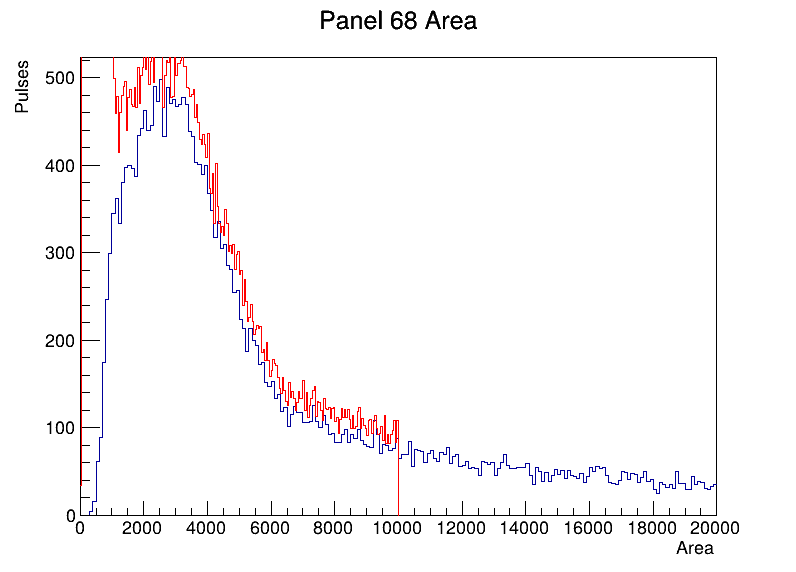

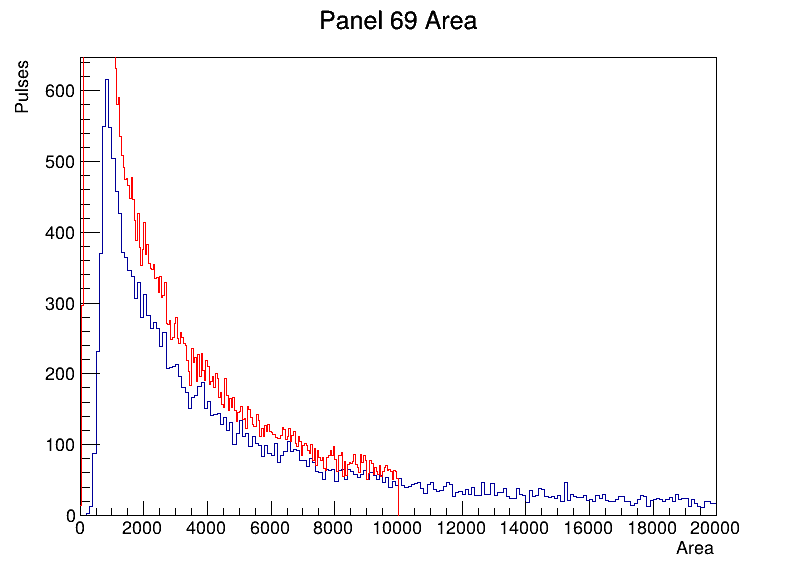

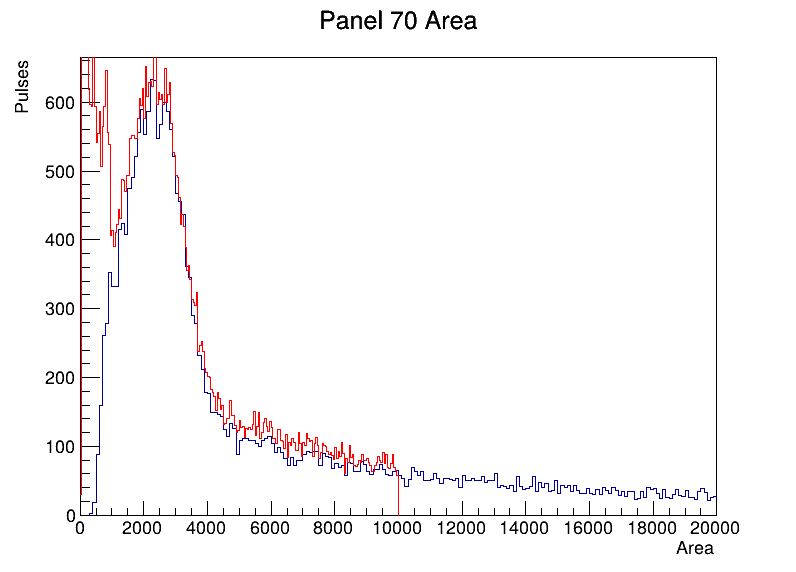

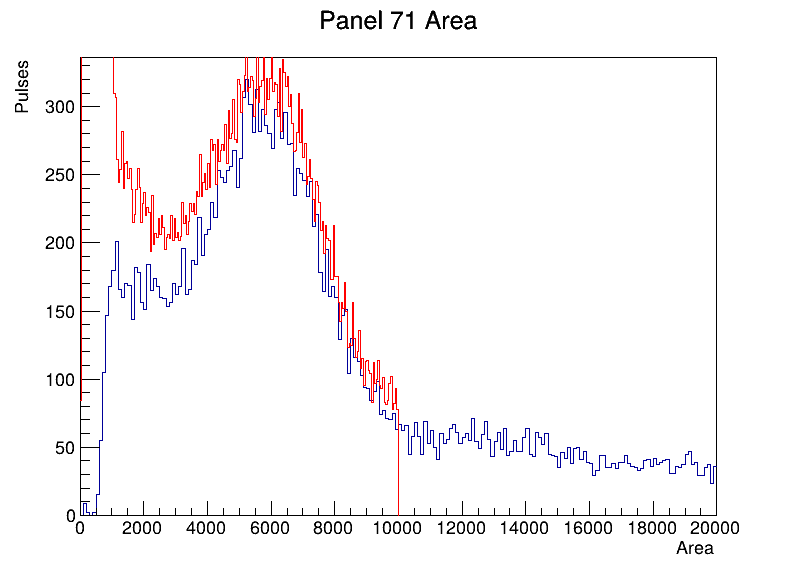

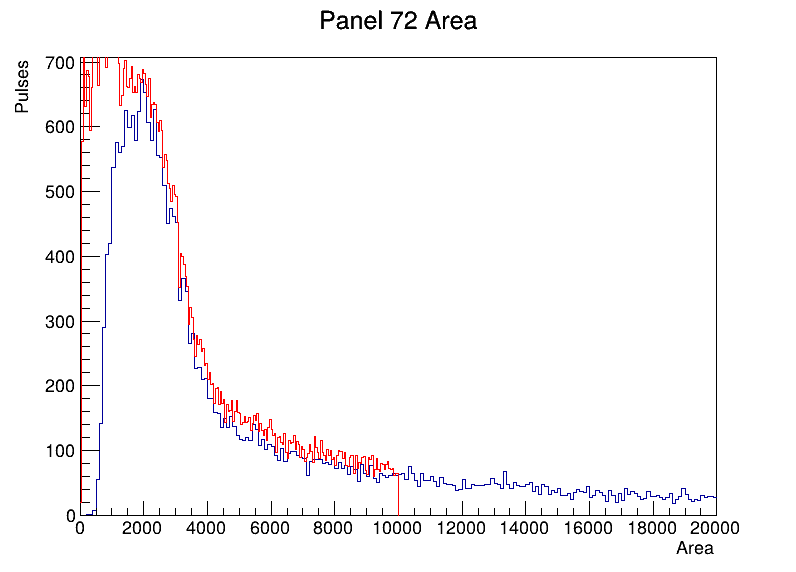

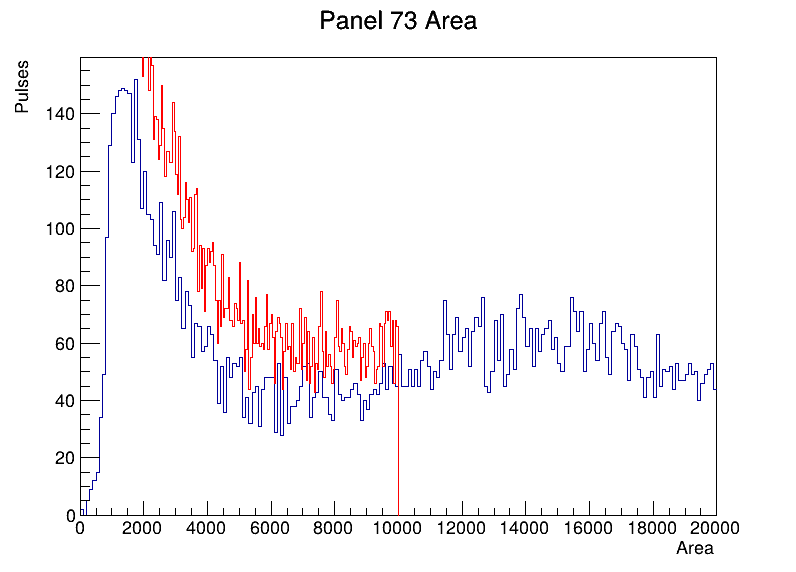

In [7]:
c68 = plotPickupTogether(h_nPE68, h_nPE68Tight, "Panel 68 Area")
c69 = plotPickupTogether(h_nPE69, h_nPE69Tight, "Panel 69 Area")
c70 = plotPickupTogether(h_nPE70, h_nPE70Tight, "Panel 70 Area")
c71 = plotPickupTogether(h_nPE71, h_nPE71Tight, "Panel 71 Area")
c72 = plotPickupTogether(h_nPE72, h_nPE72Tight, "Panel 72 Area")
c73 = plotPickupTogether(h_nPE73, h_nPE73Tight, "Panel 73 Area")


2707.93
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      18.7898
NDf                       =           27
Edm                       =  8.34492e-07
NCalls                    =          136
Constant                  =      474.783   +/-   4.9944      
Mean                      =      2707.93   +/-   37.879      
Sigma                     =      1959.86   +/-   84.9032      	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c68
Info in <TCanvas::Print>: png file channel68SPEFit.png has been created


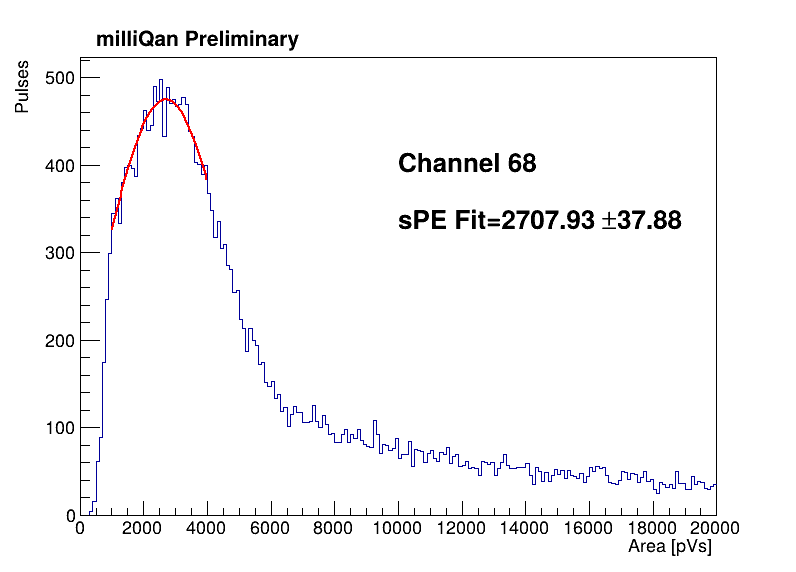

In [20]:
c68 = r.TCanvas("c68", "c68", 800, 600)
c68.cd()
f68 = r.TF1("f1", "gaus", 1000, 6000)

h_nPE68Tight.SetTitle(';Area [pVs];Pulses')
h_nPE68Tight.Draw()
h_nPE68Tight.Fit(f68, "P", "", 1000, 4000)

mean = round(f68.GetParameter(1), 2)
err = round(f68.GetParError(1), 2)
print(mean)

t1 = r.TLatex()
t1.SetNDC()
t1.DrawLatex(0.5, 0.6, f"sPE Fit={mean}#pm{err}")

t2 = r.TLatex()
t2.SetNDC()
t2.DrawLatex(0.5, 0.7, 'Channel 68')

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.12, 0.92, "milliQan Preliminary");

c68.Draw()
c68.SaveAs('channel68SPEFit.png')

1166.01
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      65.2838
Chi2                      =      130.568
NDf                       =           10
Edm                       =  1.32307e-06
NCalls                    =          545
p0                        =     0.330044   +/-   0.162446    
p1                        =      1166.01   +/-   12.5602     
p2                        =       258.49   +/-   15.8842     


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c69


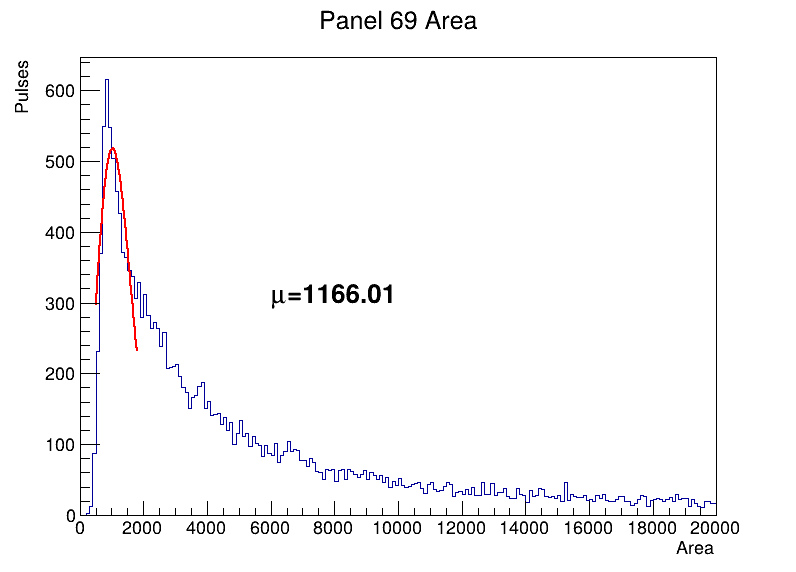

In [11]:
c69 = r.TCanvas("c69", "c69", 800, 600)
c69.cd()
#f69 = r.TF1("f69", "gaus", 1000, 6000)
f69 = r.TF1("f69", "[0]*TMath::Power(([1]/[2]),(x/[2]))*(TMath::Exp( ([1]/[2])))/TMath::Gamma((x/[2])+1)", 1000, 6000)
f69.SetParameter(0, 100)
f69.SetParameter(1, 1000)
f69.SetParameter(2, 1000)

h_nPE69Tight.Draw()
h_nPE69Tight.Fit(f69, "SLL", "", 500, 1800)

mean = round(f69.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(6000, 300, f"#mu={mean}")

c69.Draw()

2296.06
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      30.5561
NDf                       =           27
Edm                       =  2.24564e-08
NCalls                    =          100
Constant                  =      608.694   +/-   7.6126      
Mean                      =      2296.06   +/-   14.8202     
Sigma                     =      1074.47   +/-   19.0447      	 (limited)


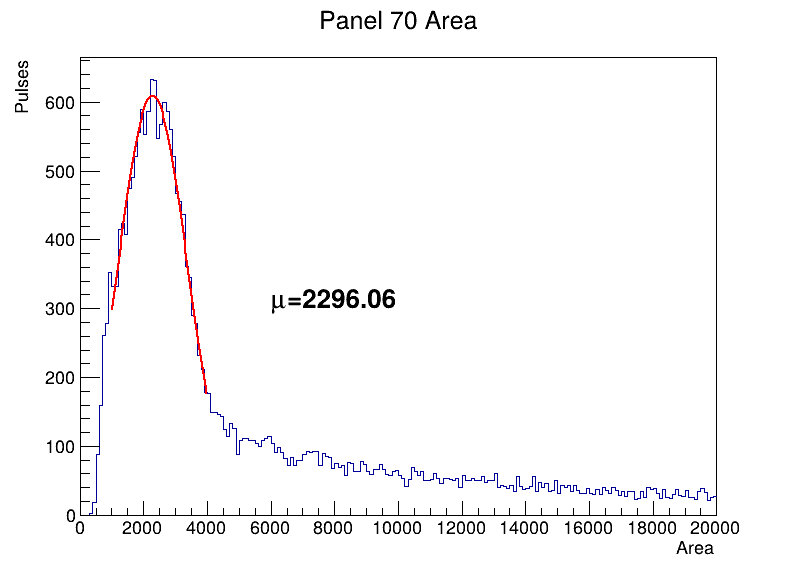

In [10]:
c70 = r.TCanvas("c70", "c70", 800, 600)
c70.cd()
f70 = r.TF1("f70", "gaus", 1000, 6000)

h_nPE70Tight.Draw()
h_nPE70Tight.Fit(f70, "P", "", 1000, 4000)

mean = round(f70.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(6000, 300, f"#mu={mean}")

c70.Draw()

5719.38
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      47.6453
NDf                       =           47
Edm                       =  2.81512e-06
NCalls                    =          106
Constant                  =      293.546   +/-   3.62834     
Mean                      =      5719.38   +/-   45.1879     
Sigma                     =      2112.15   +/-   52.0831      	 (limited)


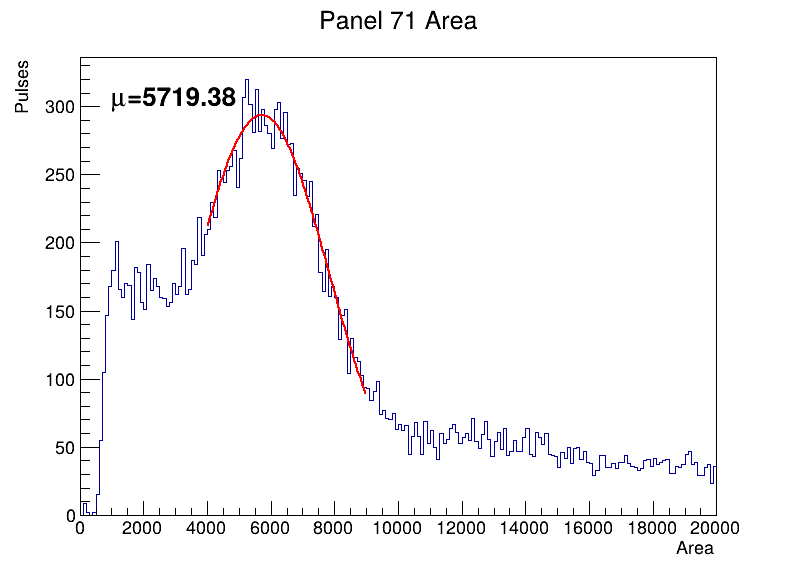

In [12]:
c71 = r.TCanvas("c71", "c71", 800, 600)
c71.cd()
f71 = r.TF1("f71", "gaus", 4000, 10000)

h_nPE71Tight.Draw()
h_nPE71Tight.Fit(f71, "P", "", 4000, 9000)

mean = round(f71.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(1000, 300, f"#mu={mean}")

c71.Draw()

1869.16
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      42.0328
Chi2                      =      84.0656
NDf                       =           59
Edm                       =  5.15367e-09
NCalls                    =          103
Constant                  =      312.449   +/-   3.2955      
Mean                      =      1869.16   +/-   27.188      
Sigma                     =      1314.09   +/-   28.7693      	 (limited)


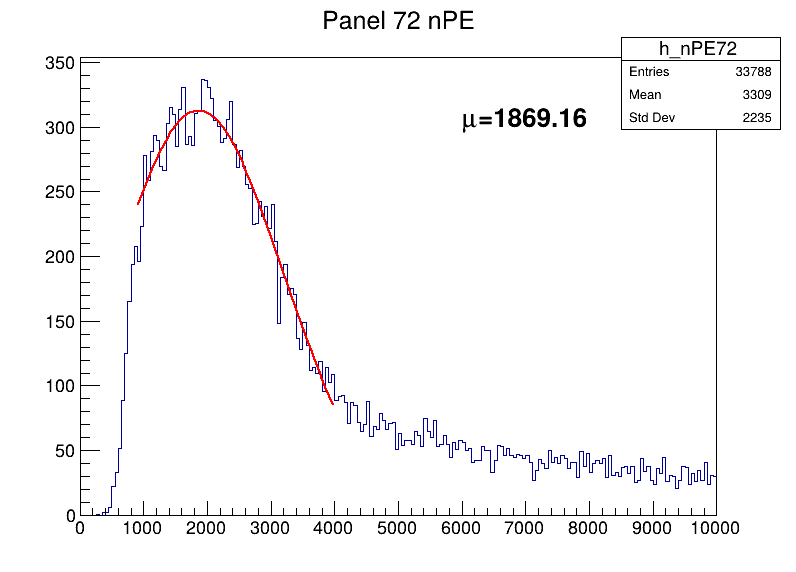

In [12]:
c72 = r.TCanvas("c72", "c72", 800, 600)
c72.cd()
f72 = r.TF1("f72", "gaus", 1000, 6000)

h_nPE72Tight.Draw()
h_nPE72Tight.Fit(f72, "L", "", 900, 4000)

mean = round(f72.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(6000, 300, f"#mu={mean}")

c72.Draw()

1894.83
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      32.1005
Chi2                      =       64.201
NDf                       =           41
Edm                       =  6.70245e-09
NCalls                    =          345
p0                        =      5.72168   +/-   3.59165     
p1                        =      1894.83   +/-   63.2418     
p2                        =      1030.05   +/-   208.613     


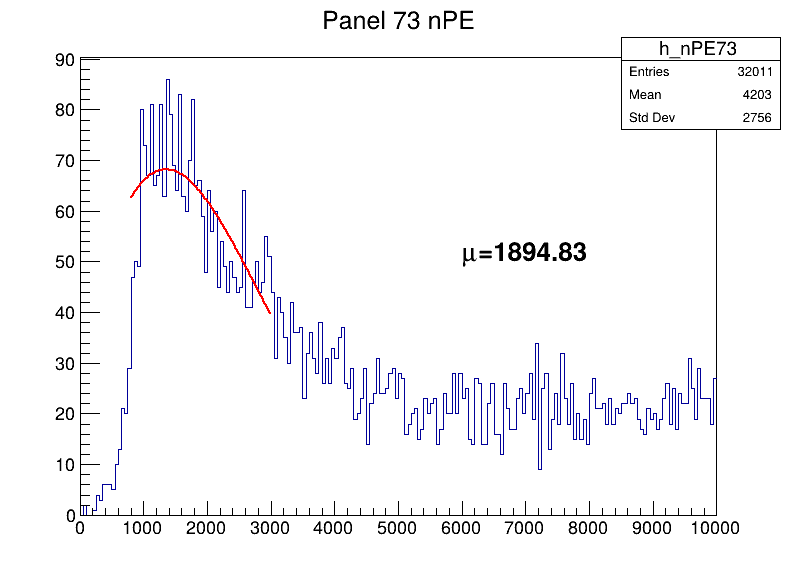

In [13]:
c73 = r.TCanvas("c73", "c73", 800, 600)
c73.Clear()
c73.cd()

#f73 = r.TF1("f73", "gaus", 500, 6000)
f73 = r.TF1("f73", "[0]*TMath::Power(([1]/[2]),(x/[2]))*(TMath::Exp( ([1]/[2])))/TMath::Gamma((x/[2])+1)", 1000, 6000)
f73.SetParameter(0, 100)
f73.SetParameter(1, 1000)
f73.SetParameter(2, 1000)

h_nPE73Tight.Draw()
h_nPE73Tight.Fit(f73, "SLL", "", 800, 3000)

mean = round(f73.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(6000, 50, f"#mu={mean}")

c73.Draw()

4830.3
****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      55.6906
Chi2                      =      111.381
NDf                       =          128
Edm                       =  1.80821e-07
NCalls                    =           92
Constant                  =      45.8249   +/-   0.883514    
Mean                      =       4830.3   +/-   170.229     
Sigma                     =      4858.56   +/-   158.642      	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c74


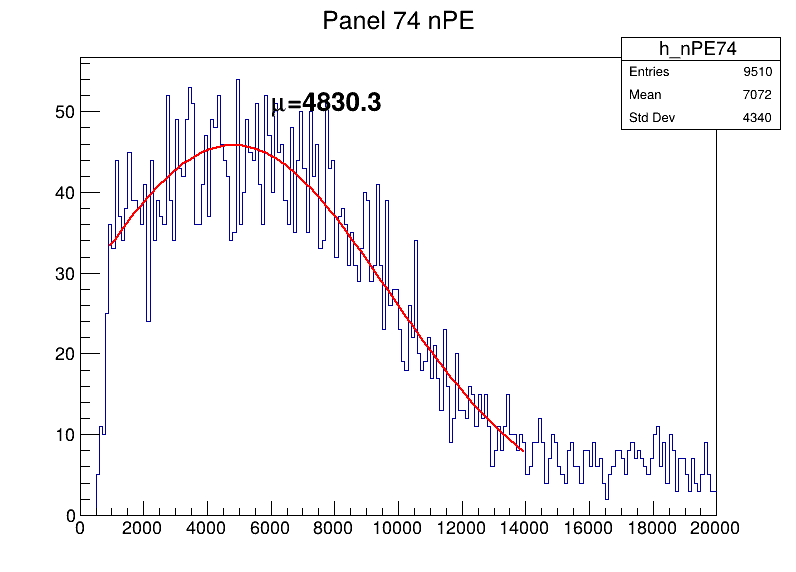

In [27]:
c74 = r.TCanvas("c74", "c74", 800, 600)
c74.cd()
f74 = r.TF1("f74", "gaus", 1000, 18000)

h_nPE74Tight.Draw()
h_nPE74Tight.Fit(f74, "L", "", 900, 14000)

mean = round(f74.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(6000, 50, f"#mu={mean}")

c74.Draw()

In [1]:
c75 = r.TCanvas("c75", "c75", 800, 600)
c75.cd()
f75 = r.TF1("f75", "gaus", 1000, 6000)

h_nPE75Tight.Draw()
h_nPE75Tight.Fit(f75, "L", "", 900, 4000)

mean = round(f75.GetParameter(1), 2)
print(mean)

t1 = r.TLatex()
t1.DrawLatex(6000, 80, f"#mu={mean}")

c75.Draw()

NameError: name 'r' is not defined

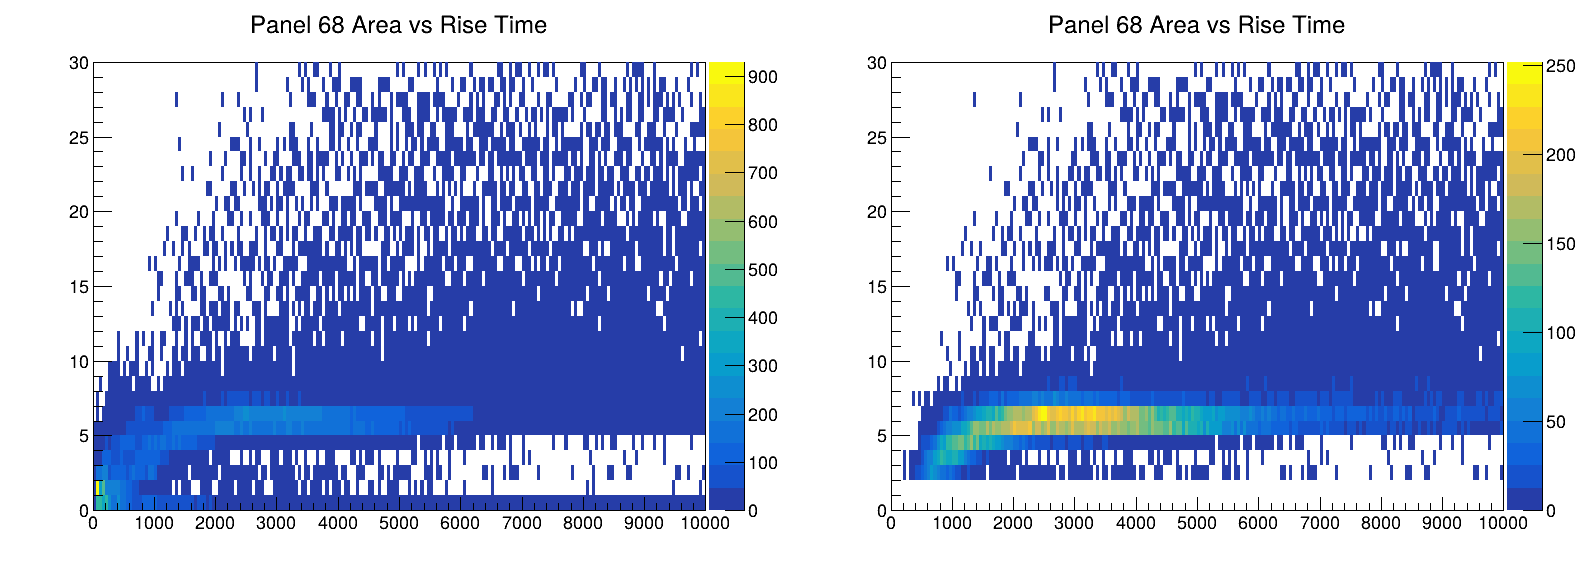

In [16]:
#plot rise vs area

c2 = r.TCanvas("c2", "c2", 1600, 600)
c2.Divide(2, 1)

c2.cd(1)
h_riseArea68 = fin2.Get('h_riseArea68')
h_riseArea68.Draw('colz')
c2.cd(2)
h2_riseArea68 = fin.Get('h_riseArea68')
h2_riseArea68.Draw('colz')
c2.Draw()

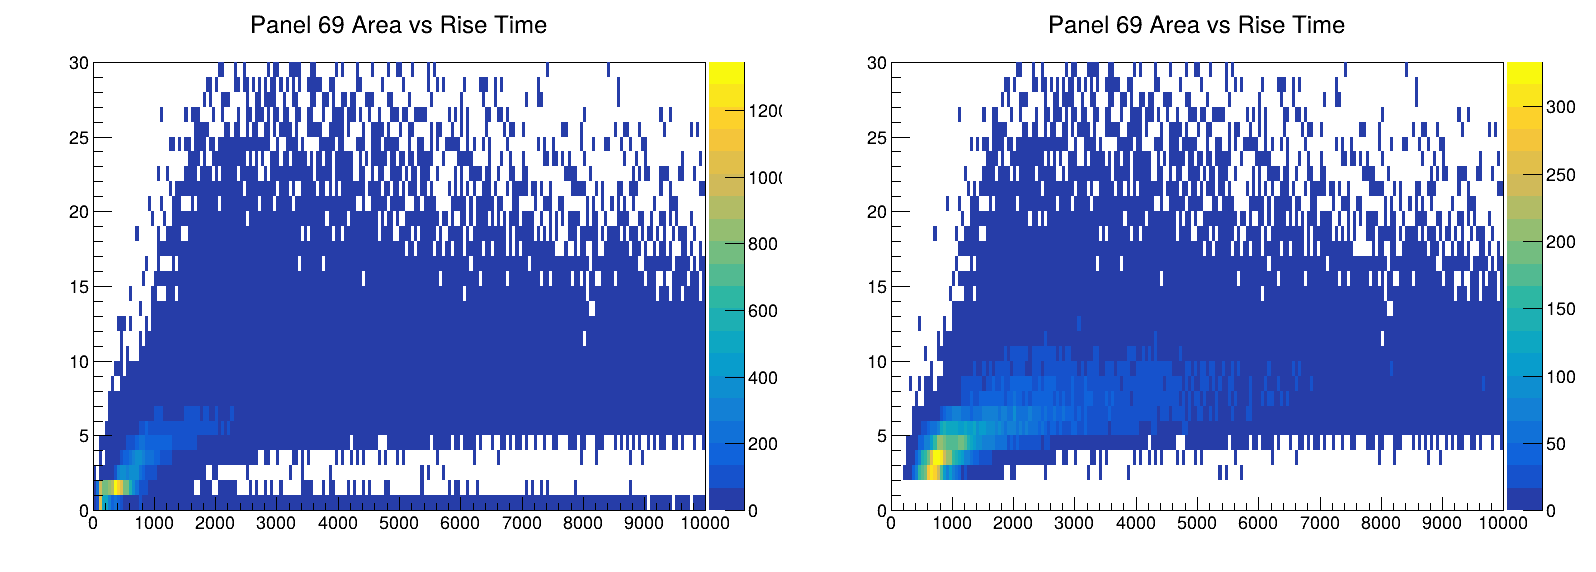

In [17]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_riseArea69')
h_riseArea68.Draw('colz')
c2.cd(2)
h2_riseArea68 = fin.Get('h_riseArea69')
h2_riseArea68.Draw('colz')
c2.Draw()

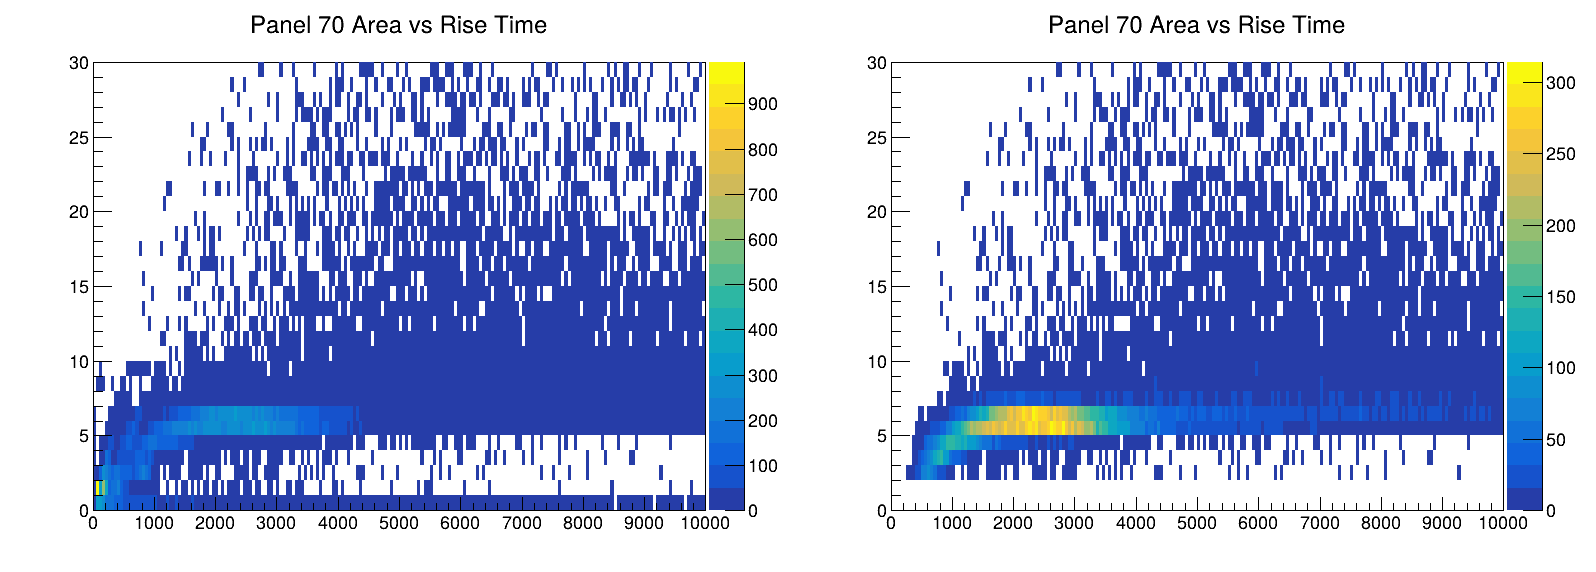

In [18]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_riseArea70')
h_riseArea68.Draw('colz')
c2.cd(2)
h2_riseArea68 = fin.Get('h_riseArea70')
h2_riseArea68.Draw('colz')
c2.Draw()

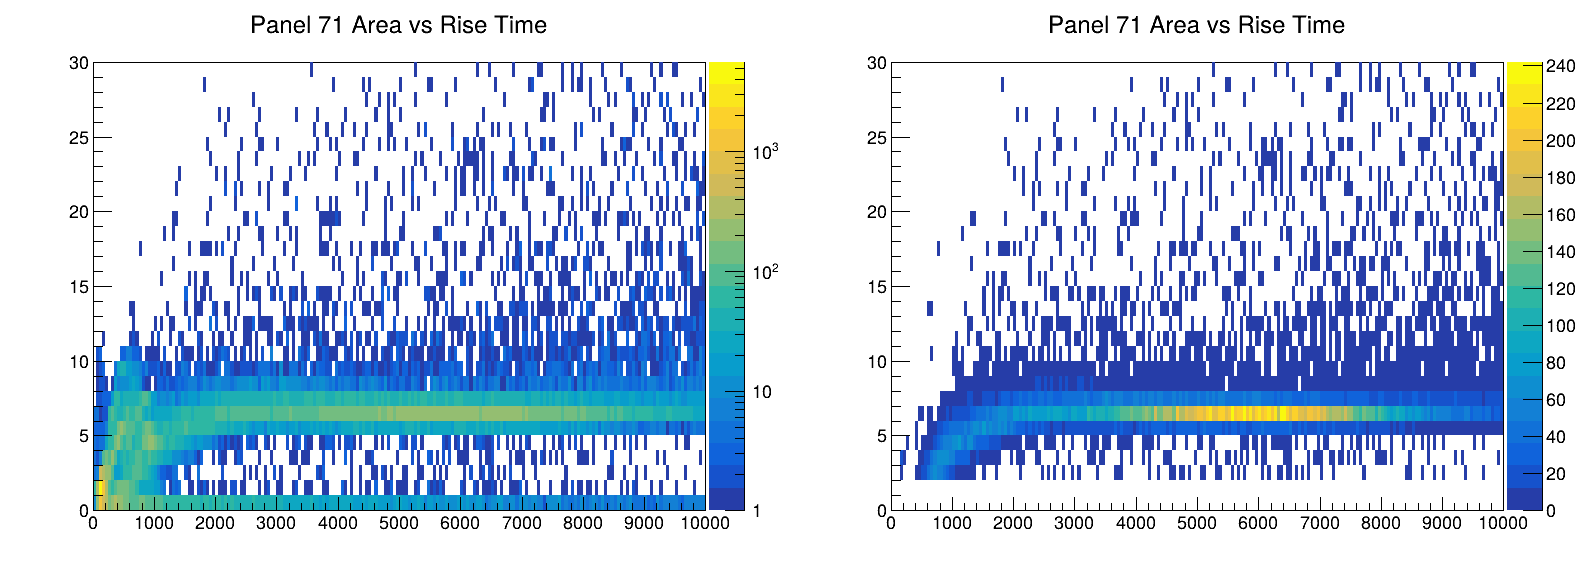

In [19]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_riseArea71')
h_riseArea68.Draw('colz')
r.gPad.SetLogz()
c2.cd(2)
h2_riseArea68 = fin.Get('h_riseArea71')
h2_riseArea68.Draw('colz')
c2.Draw()

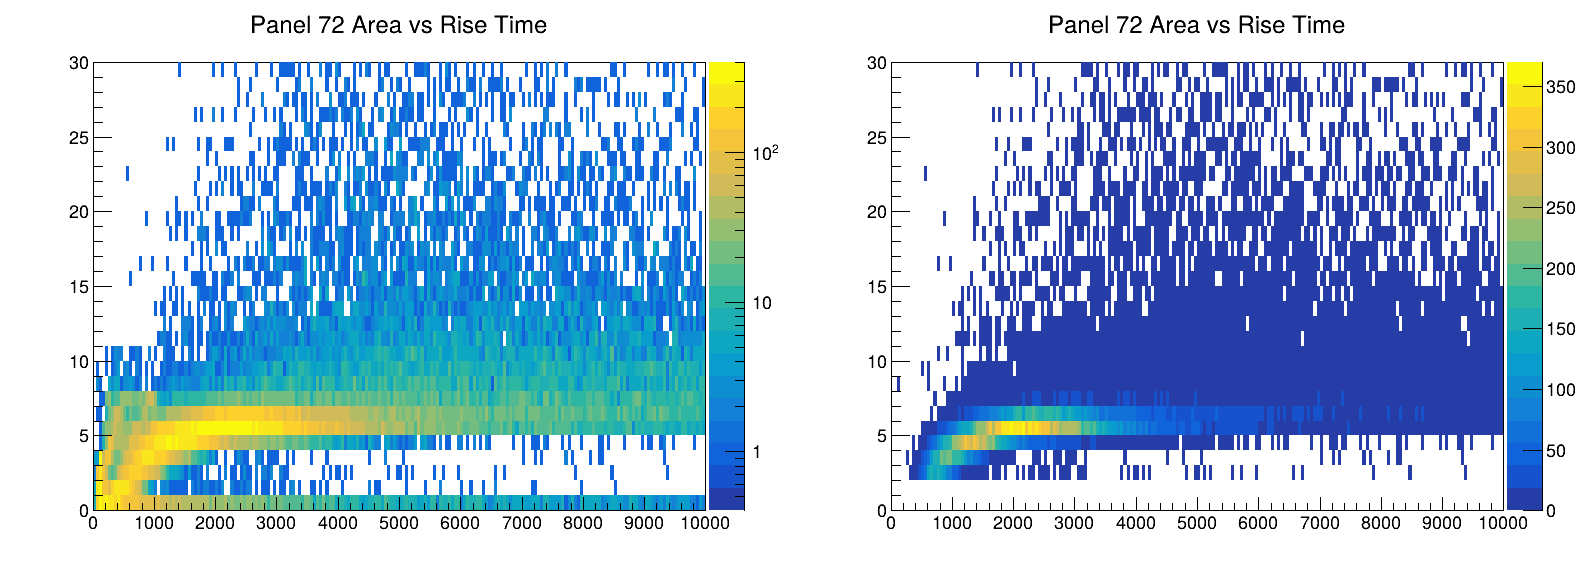

In [20]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_riseArea72')
h_riseArea68.Draw('colz')
c2.cd(2)
h2_riseArea68 = fin.Get('h_riseArea72')
h2_riseArea68.Draw('colz')
c2.Draw()

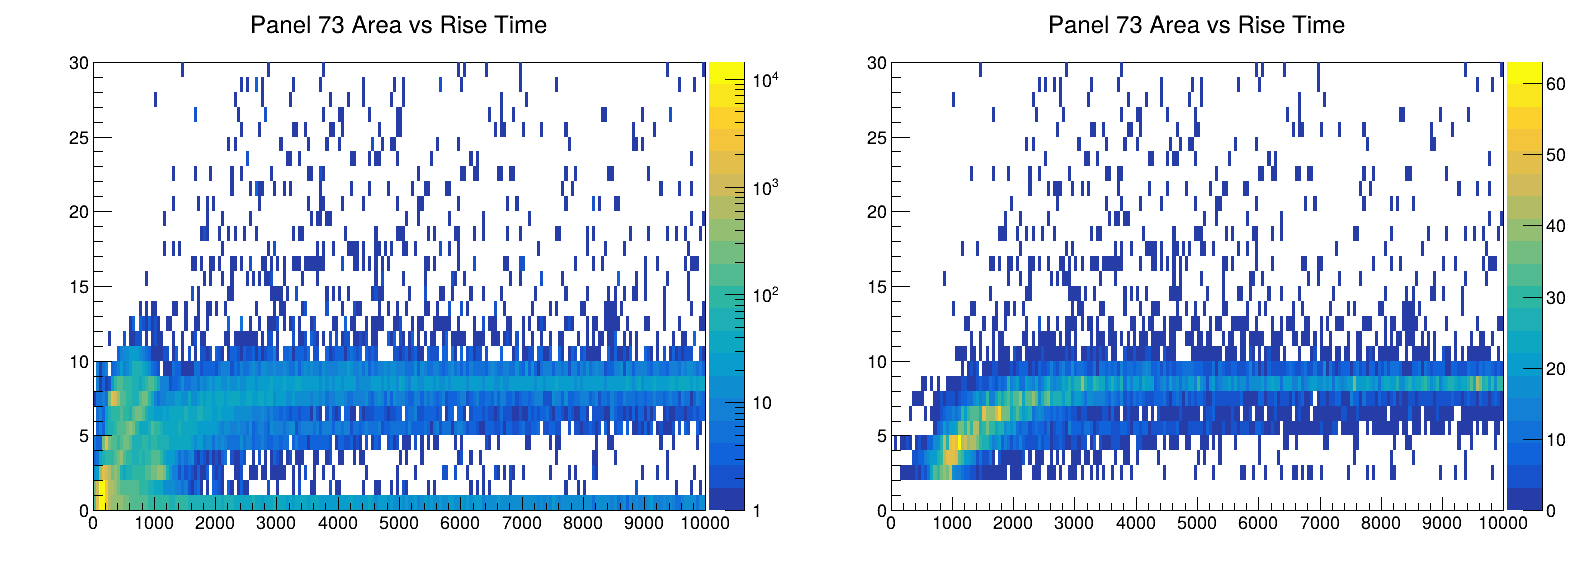

In [21]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_riseArea73')
h_riseArea68.Draw('colz')
r.gPad.SetLogz()
c2.cd(2)
h2_riseArea68 = fin.Get('h_riseArea73')
h2_riseArea68.Draw('colz')
c2.Draw()


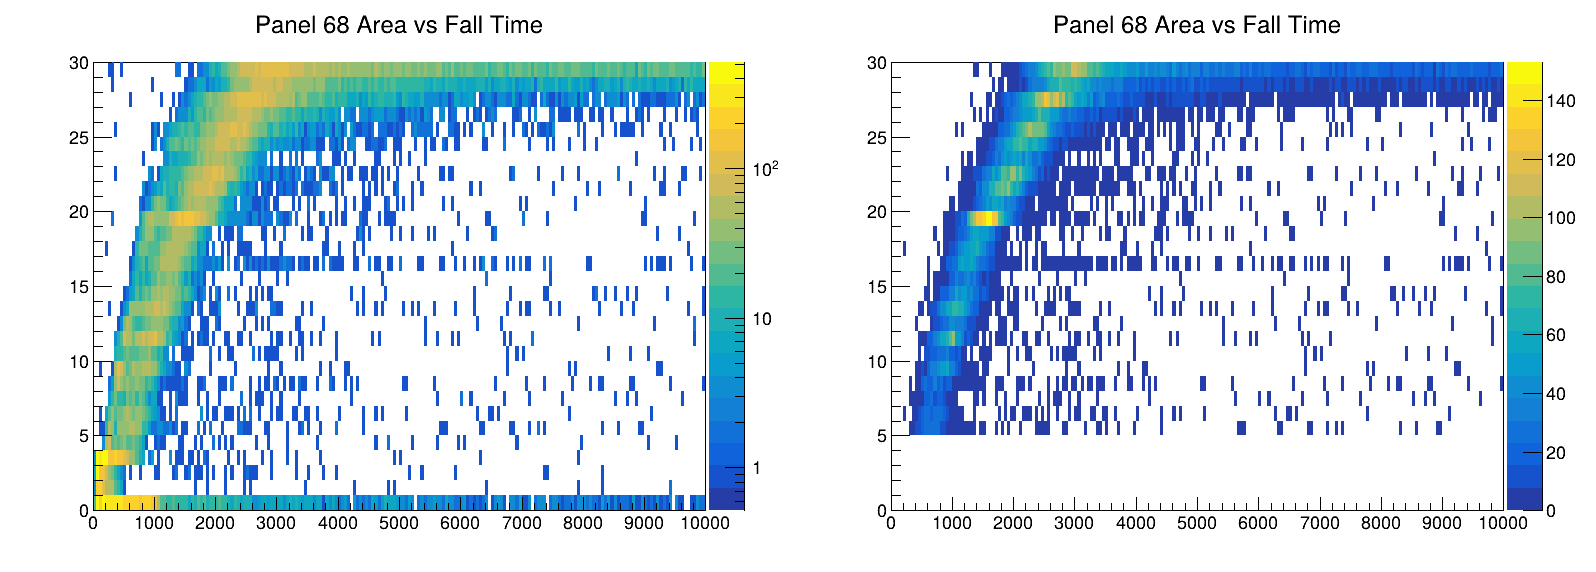

In [22]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_fallArea68')
h_riseArea68.Draw('colz')
r.gPad.SetLogz()
c2.cd(2)
h2_riseArea68 = fin.Get('h_fallArea68')
h2_riseArea68.Draw('colz')
c2.Draw()


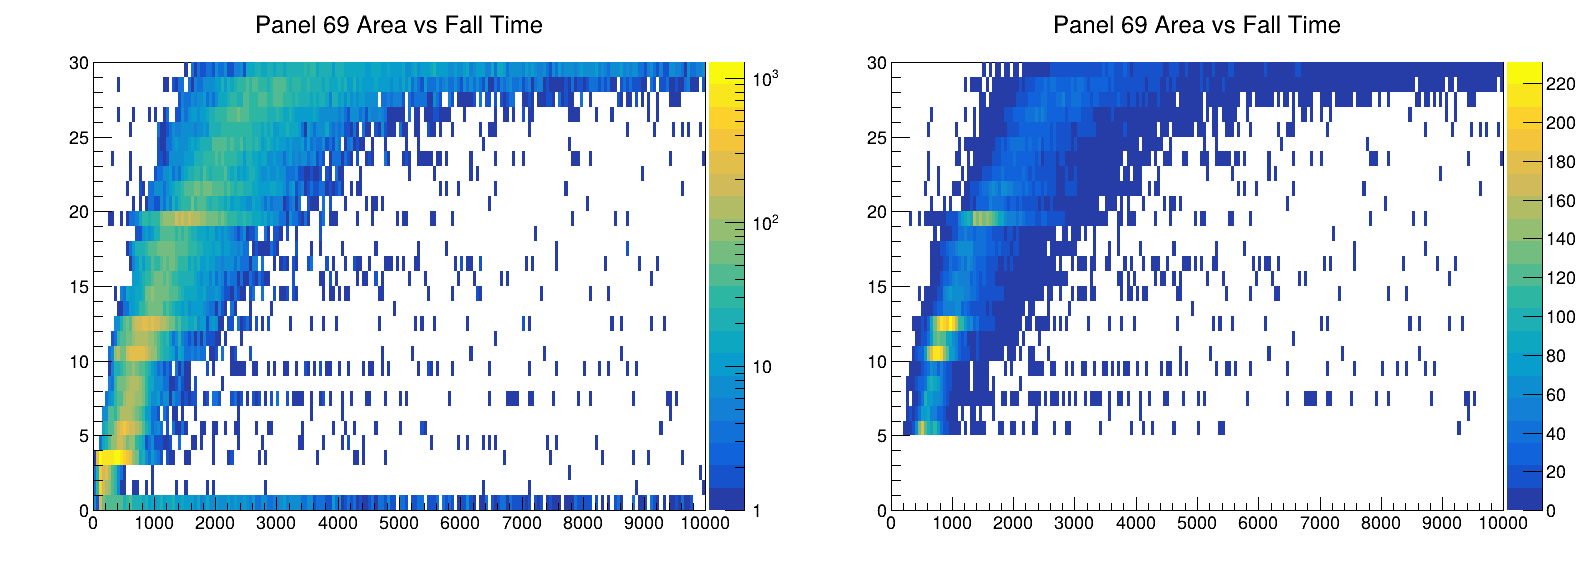

In [23]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_fallArea69')
h_riseArea68.Draw('colz')
r.gPad.SetLogz()
c2.cd(2)
h2_riseArea68 = fin.Get('h_fallArea69')
h2_riseArea68.Draw('colz')
c2.Draw()

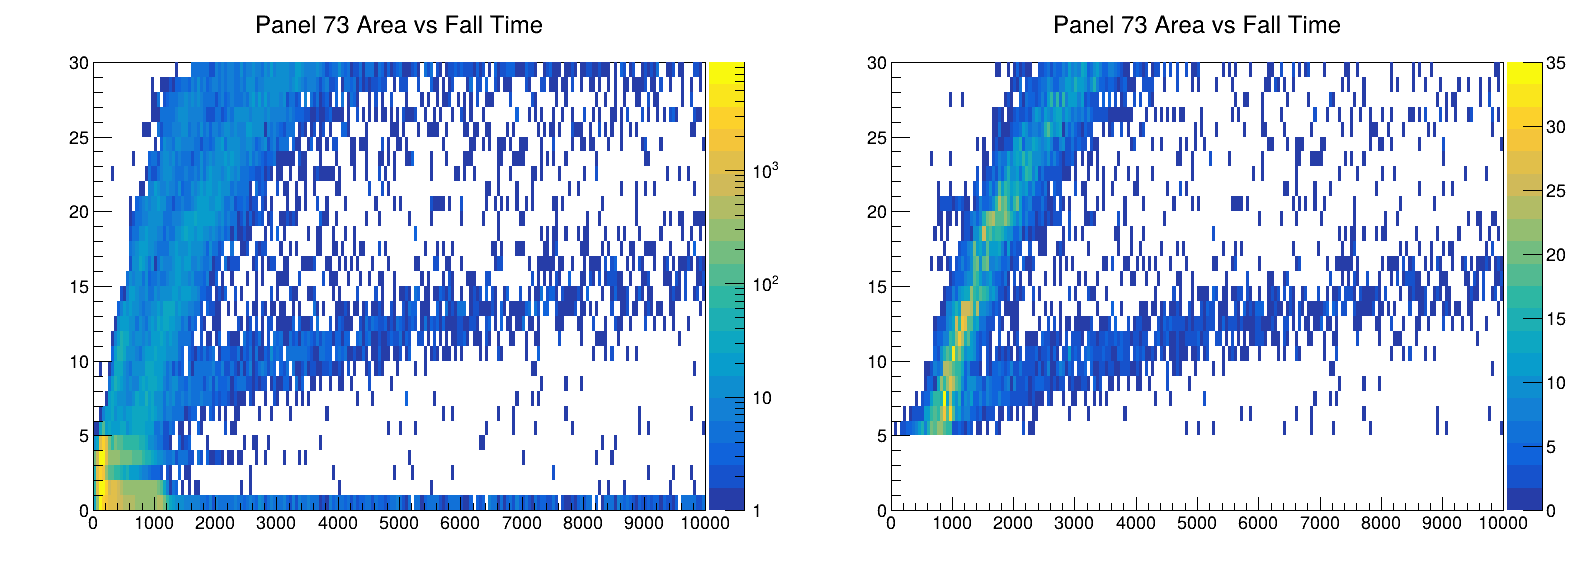

In [24]:
c2.cd(1)
h_riseArea68 = fin2.Get('h_fallArea73')
h_riseArea68.Draw('colz')
r.gPad.SetLogz()
c2.cd(2)
h2_riseArea68 = fin.Get('h_fallArea73')
h2_riseArea68.Draw('colz')
c2.Draw()

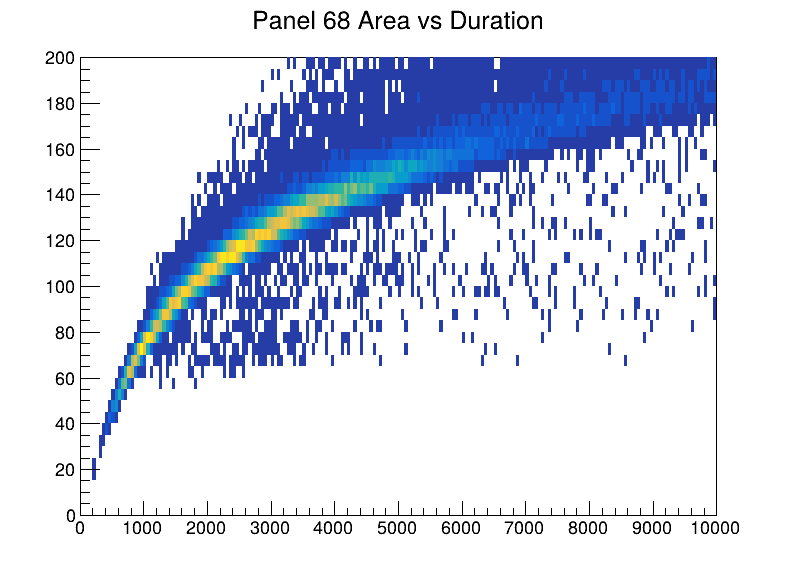

In [55]:
c1.cd()
h_durationArea68 = fin.Get('h_durationArea68')
h_durationArea68.GetYaxis().SetRangeUser(0, 200)
h_durationArea68.Draw()
c1.Draw()

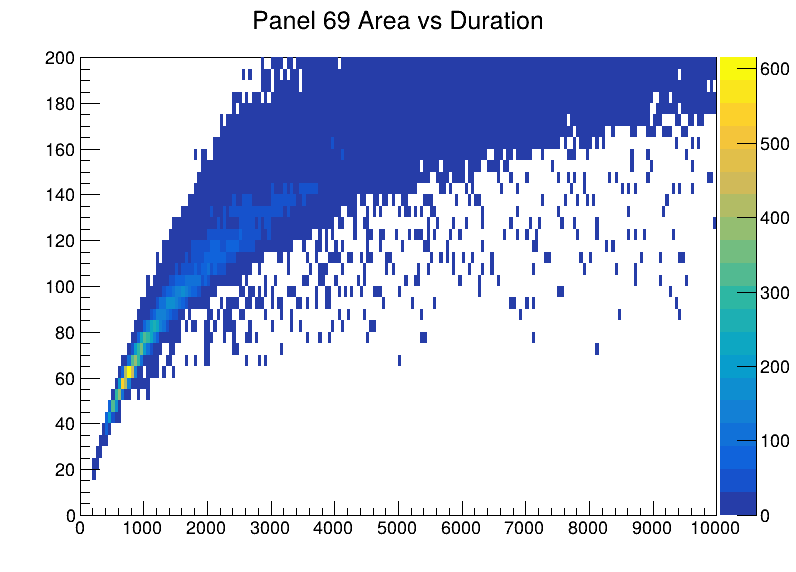

In [57]:
c1.cd()
h_durationArea68 = fin.Get('h_durationArea69')
h_durationArea68.GetYaxis().SetRangeUser(0, 200)
h_durationArea68.Draw('colz')
c1.Draw()

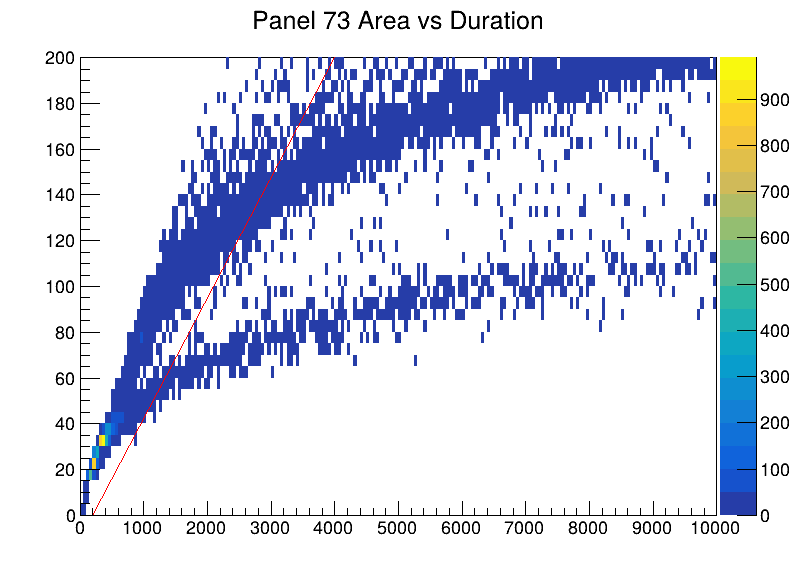

In [5]:
c1.cd()
r.gStyle.SetOptStat(0)
h_durationArea73 = fin.Get('h_durationArea73')
h_durationArea73.GetYaxis().SetRangeUser(0, 200)
h_durationArea73.Draw('colz')
l1 = r.TLine(200, 0, 4000, 200)
l1.SetLineColor(r.kRed)
l1.Draw("same")
c1.Draw()

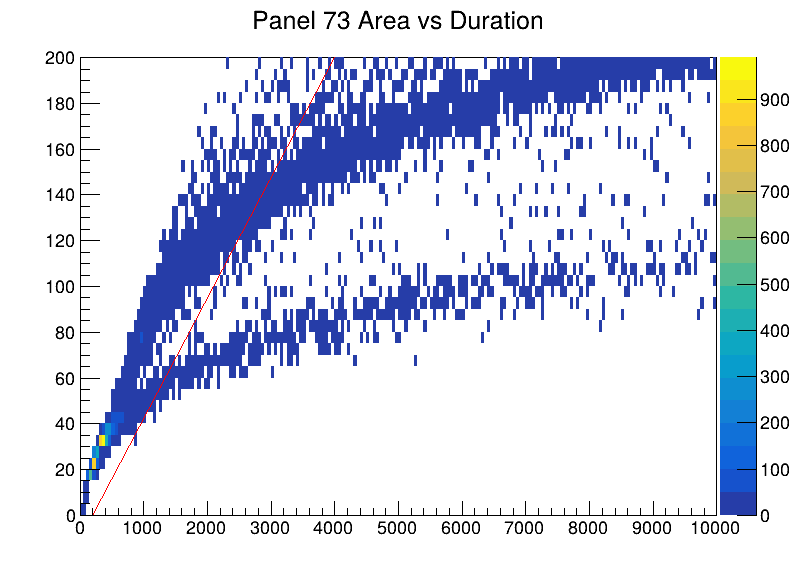

In [6]:
c1.Draw()

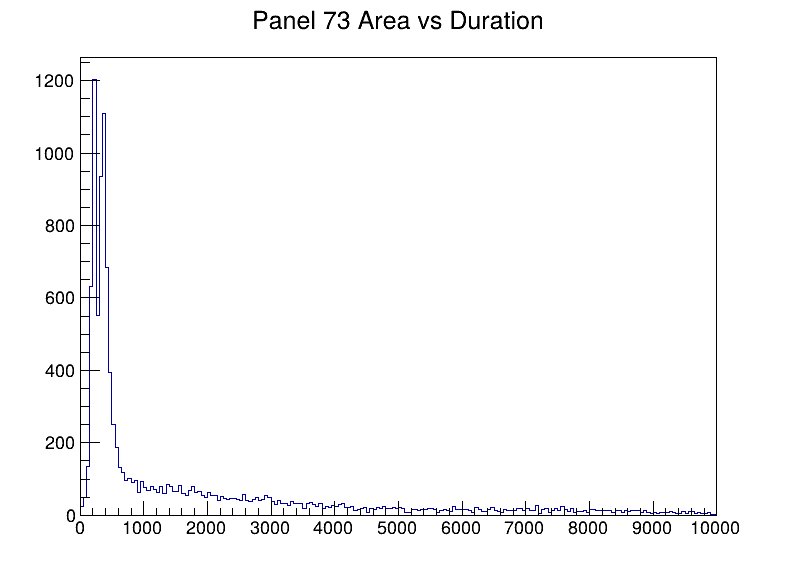

In [7]:
cut = r.TCutG('cut', 6)
cut.SetPoint(0, 200, 0)
cut.SetPoint(1, 1000, 55)
cut.SetPoint(2, 10000, 160)
cut.SetPoint(3, 10000, 200)
cut.SetPoint(4, 0, 200)
cut.SetPoint(5, 0, 0)
cut.SetPoint(6, 200, 0)
#cut.SetVarX('x')
#cut.SetVarY('y')
h_durationCut = h_durationArea73.ProjectionX("h_durationCut", 1, h_durationArea73.GetNbinsX(), '[cut]')
h_durationCut.Draw()
c1.Draw()

In [ ]:
c3 = r.TCanvas("c3", "c3", 1200, 600)
c3.Divide(2, 1)
c3.cd(1)
h_nPE73Tight.Draw()
c3.cd(2)
h_durationCut.Draw()
c3.Draw()

In [ ]:
f2 = r.TF2("f2","xygaus + xygaus(5) + xylandau(10)",-4,4,-4,4)                 
params = np.array([130,-1.4,1.8,1.5,1, 150,2,0.5,-2,0.5, 3600,-2,0.7,-3,0.3])
f2.SetParameters(params)                                                     
h2 = r.TH2F("h2","xygaus + xygaus(5) + xylandau(10)",20,-4,4,20,-4,4)          
h2.SetFillColor(46)                                                          
h2.FillRandom("f2",40000)                                                    
                                                                             
can= r.TCanvas('can','canvas',800,600)                                         
can.cd()                                                                     
                                                                             
myCut = r.TCutG('mycut',5)                                                     
myCut.SetPoint(0,-1,-1)                                                      
myCut.SetPoint(1,-1,1)                                                       
myCut.SetPoint(2,1,1)                                                        
myCut.SetPoint(3,1,-1)                                                       
myCut.SetPoint(4,-1,-1)                                                      
                                                                             
#h2.Draw('colz[mycut]')                                                       
#myCut.Draw()                                                                 
                                                                             
h2Proj = h2.ProjectionX('noCut')                                             
h2ProjCut = h2.ProjectionX('yesCut',1,h2.GetNbinsX(),'[mycut]')              
                                                                             
h2Proj.Draw('hist')                                                          
                                                                             
h2ProjCut.Draw('hist')    
can.Draw()